# EMBS-BHI-2025: Robust and Reproducible AI Tutorial

Tutorial instructors: Ernest Namdar and Pascal Tyrrell

The dataset used in this tutorial is adopted from Openradiomics (BraTS 2020). https://pubmed.ncbi.nlm.nih.gov/40760408/

This notebook explores confidence estimation strategies for a Random Forest classifier using the tutorial radiomics dataset.

## Confidence in Machine Learning
Multiple approaches exist to quantify how confident a model is in its predictions. Here we look at three complementary tactics:
1. **Output probability** – use the classifier's predicted probability as a direct confidence score.
2. **Input perturbation** – lightly perturb the input and observe how much the prediction changes.
3. **Ensemble agreement** – compare predictions across multiple models trained on the same data with varied initializations.

## Setup
Import the libraries used throughout the notebook and establish deterministic seeds for reproducibility.

In [1]:
import os
import random
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

SEED = 0
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [2]:
# Comment out this cell if you run the code locally
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# --- Set working directory ---
import os

project_path = '/content/drive/MyDrive/EMBS_BHI_2025_Tutorial_Robust_and_Reproducible_AI/Part1-Classification/code'

# Change the working directory
os.chdir(project_path)

# Verify
print("Current working directory:", os.getcwd())

Mounted at /content/drive
Current working directory: /content/drive/MyDrive/EMBS_BHI_2025_Tutorial_Robust_and_Reproducible_AI/Part1-Classification/code


## Load and Prepare the Dataset
We reuse the radiomics dataset packaged with this tutorial, dropping metadata columns so the model is trained only on numeric features.

In [3]:
DATA_PATH = '../data/Radiomics_NoNormalization_Whole_Tumor_T1CE.csv'

df = pd.read_csv(DATA_PATH)

In [4]:
df

,Lesion_ID,Group,Group_label,Patient_ID,Normalization,Subregion,Sequence,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,...,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_ZoneEntropy,wavelet-LLL_glszm_ZonePercentage,wavelet-LLL_glszm_ZoneVariance,wavelet-LLL_ngtdm_Busyness,wavelet-LLL_ngtdm_Coarseness,wavelet-LLL_ngtdm_Complexity,wavelet-LLL_ngtdm_Contrast,wavelet-LLL_ngtdm_Strength
0,1,LGG,0,BraTS20_Training_264,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,257.875481,0.002917,7.129410,0.068842,1.065569e+04,1.857225,0.001056,402.594060,0.057651,0.400334
1,2,LGG,0,BraTS20_Training_333,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,31400.796681,0.000034,9.194488,0.550131,5.733321e+00,0.037253,0.000198,615308.179535,0.086944,37.474497
2,3,LGG,0,BraTS20_Training_290,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,687.290391,0.001712,7.892693,0.031033,4.019240e+05,1.891263,0.000142,1546.563118,0.005046,0.767814
3,4,LGG,0,BraTS20_Training_269,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,14.038038,0.055507,5.427283,0.004712,1.996953e+06,34.988012,0.000462,11.145451,0.005164,0.024456
4,5,LGG,0,BraTS20_Training_263,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,799.617583,0.000725,7.988775,0.117867,5.486999e+03,0.454818,0.000960,2447.225716,0.047115,3.002776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,365,HGG,1,BraTS20_Training_207,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,250.731263,0.003331,7.412216,0.055957,3.441931e+04,2.054098,0.000544,586.352427,0.032293,0.458392
365,366,HGG,1,BraTS20_Training_192,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,994.351189,0.001169,7.464253,0.117230,3.670582e+04,2.321920,0.000186,2915.452880,0.036619,0.935791
366,367,HGG,1,BraTS20_Training_007,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,1122.955449,0.001012,7.625789,0.249371,2.043887e+03,0.674250,0.000442,8412.504297,0.069797,2.593628
367,368,HGG,1,BraTS20_Training_235,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,2511.604246,0.000511,8.163777,0.277927,3.428665e+03,1.032603,0.000163,17448.583739,0.088018,1.784128


In [5]:
y = df['Group_label']
X = df.drop(columns=[
    'Lesion_ID', 'Group', 'Group_label', 'Patient_ID',
    'Normalization', 'Subregion', 'Sequence'
] + [col for col in df.columns if col.startswith('diag')])

lb = LabelBinarizer()
y_bin = lb.fit_transform(y).ravel()

print('Feature matrix shape:', X.shape)
print('Label vector shape:', y.shape)

Feature matrix shape: (369, 1688)
Label vector shape: (369,)


There are 369 patients in the dataset (BraTS 2020) and 1688 radiomics features were extracted for each patient.

## Single Train/Test Split
We use a single stratified split so that all confidence estimates reference the same model and test set.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.25, random_state=SEED, stratify=y_bin
)

base_clf = RandomForestClassifier(random_state=SEED)
base_clf.fit(X_train, y_train)

base_test_proba = base_clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, base_test_proba)
print(f'AUROC: {auc:.3f}')

AUROC: 0.938


## Select a Random Test Example
We pick a reproducible random example from the test split and inspect its baseline prediction.

In [7]:
rng = np.random.RandomState(SEED)
idx = rng.randint(0, len(X_test))
x_sample = X_test.iloc[[idx]]
true_label = y_test[idx]
prob_positive = base_test_proba[idx]
pred_label = int(prob_positive >= 0.5)

print(f'Selected test index: {idx}')
print(f'True label: {true_label}')
print(f'Predicted label: {pred_label}')
print(f'Probability-based confidence (positive class): {prob_positive:.3f}')

Selected test index: 44
True label: 1
Predicted label: 1
Probability-based confidence (positive class): 0.920


## Input Perturbation Confidence
We lightly perturb the feature vector (5% of feature magnitude, minimum 0.05 absolute) 100 times and track how the predicted probability varies.

Input perturbation confidence range:
  min=0.560, max=0.760


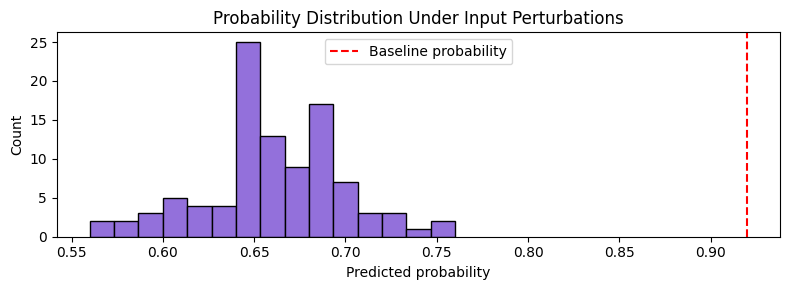

In [8]:
n_perturbations = 100
perturb_rng = np.random.RandomState(SEED + 1)
base_array = x_sample.values
relative_scale = np.maximum(np.abs(base_array), 1.0)
noise = perturb_rng.normal(loc=0.0, scale=0.05, size=(n_perturbations, base_array.shape[1]))
perturbed = base_array + noise * relative_scale
perturbed_df = pd.DataFrame(perturbed, columns=X_test.columns)
perturbed_probs = base_clf.predict_proba(perturbed_df)[:, 1]

perturb_confidence = (perturbed_probs.min(), perturbed_probs.max())
print('Input perturbation confidence range:')
print(f'  min={perturb_confidence[0]:.3f}, max={perturb_confidence[1]:.3f}')
plt.figure(figsize=(8, 3))
plt.hist(perturbed_probs, bins=15, color='mediumpurple', edgecolor='black')
plt.axvline(prob_positive, color='red', linestyle='--', label='Baseline probability')
plt.title('Probability Distribution Under Input Perturbations')
plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

## Ensemble Confidence
Finally, we train nine additional Random Forests with varied seeds and hyperparameters.
The spread of ensemble predictions serves as another confidence estimate.

Ensemble configuration samples:
[{'max_depth': 5,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'n_estimators': 150,
  'random_state': 1},
 {'max_depth': 10,
  'max_features': 'log2',
  'min_samples_leaf': 2,
  'n_estimators': 180,
  'random_state': 2},
 {'max_depth': 15,
  'max_features': None,
  'min_samples_leaf': 1,
  'n_estimators': 200,
  'random_state': 3}]
Ensemble probability range:
  min=0.759, max=0.928


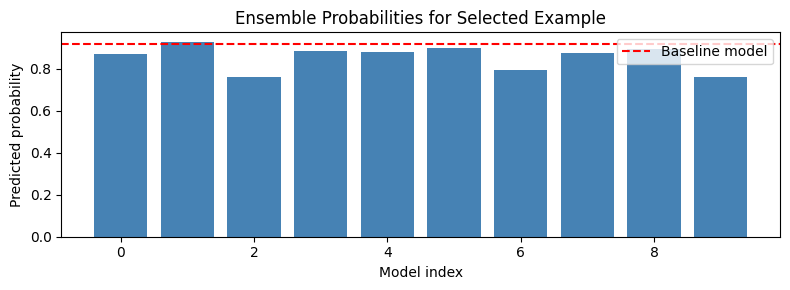

In [9]:
#using the same random example idx
sample_df = X_test.iloc[[idx]].copy()

ensemble_configs = [
    {'n_estimators': 150, 'max_depth': 5,  'max_features': 'sqrt', 'min_samples_leaf': 1, 'random_state': SEED+1},
    {'n_estimators': 180, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'random_state': SEED+2},
    {'n_estimators': 200, 'max_depth': 15, 'max_features': None,  'min_samples_leaf': 1, 'random_state': SEED+3},
    {'n_estimators': 220, 'max_depth': None,'max_features': 'sqrt','min_samples_leaf': 3, 'random_state': SEED+4},
    {'n_estimators': 250, 'max_depth': 5,  'max_features': 'log2', 'min_samples_leaf': 2, 'random_state': SEED+5},
    {'n_estimators': 180, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'random_state': SEED+6},
    {'n_estimators': 200, 'max_depth': 15, 'max_features': None,  'min_samples_leaf': 1, 'random_state': SEED+7},
    {'n_estimators': 300, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'random_state': SEED+8},
    {'n_estimators': 280, 'max_depth': None,'max_features': 'log2','min_samples_leaf': 1, 'random_state': SEED+9},
    {'n_estimators': 160, 'max_depth': 5,  'max_features': None,  'min_samples_leaf': 2, 'random_state': SEED+10},
]

ensemble_models = []
ensemble_probs = []
for cfg in ensemble_configs:
    model = RandomForestClassifier(**cfg)
    model.fit(X_train, y_train)
    prob = model.predict_proba(sample_df)[:, 1][0]
    ensemble_models.append(model)
    ensemble_probs.append(prob)

ensemble_confidence = (float(np.min(ensemble_probs)), float(np.max(ensemble_probs)))
print('Ensemble configuration samples:')
pprint(ensemble_configs[:3])
print('Ensemble probability range:')
print(f'  min={ensemble_confidence[0]:.3f}, max={ensemble_confidence[1]:.3f}')
plt.figure(figsize=(8, 3))
plt.bar(range(len(ensemble_probs)), ensemble_probs, color='steelblue')
plt.axhline(prob_positive, color='red', linestyle='--', label='Baseline model')
plt.title('Ensemble Probabilities for Selected Example')
plt.xlabel('Model index')
plt.ylabel('Predicted probability')
plt.legend()
plt.tight_layout()
plt.show()

## Takeaways
- Output probabilities provide an immediate, interpretable confidence readout but assume the model is calibrated.
- Input perturbations reveal how sensitive predictions are to small measurement noise around a single example.
- Ensembles expose variability stemming from different model initializations and hyperparameters, a pragmatic proxy for epistemic uncertainty.